In [1]:
import torch
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.training.configs.training_configs import ProcessDatasetConfig
from pathlib import Path
import json

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint_path = Path("/workspaces/cure/compmech-models/models/54qc0vyb_mess3-0.05-0.85/")
weights = torch.load(checkpoint_path / "6406400.pt")

In [3]:
with open(checkpoint_path / "train_config.json", "r") as f:
    required_fields = ['d_vocab', 'd_model', 'n_ctx', 'd_head', 'n_heads', 'n_layers']
    cfg_dict = {k: v for k, v in json.load(f).items() if k in required_fields}
    cfg_dict['n_head'] = cfg_dict.pop('n_heads')
    cfg_dict['d_mlp'] = 4 * cfg_dict['d_model']
    train_config = RawModelConfig(**cfg_dict)

model = train_config.to_hooked_transformer(device=torch.device("cuda"))
model.load_state_dict(weights)

<All keys matched successfully>

In [4]:
dataset_config = ProcessDatasetConfig(
    process='Mess3',
    process_params={'x': 0.5, 'a': 0.85},
    batch_size=64,
    num_tokens=500000,
    test_split=0.01
)

train_loader = dataset_config.to_dataloader(sequence_length=cfg_dict["n_ctx"], train=True)
test_loader = dataset_config.to_dataloader(sequence_length=cfg_dict["n_ctx"], train=False)

In [5]:
from epsilon_transformers.process.processes import Mess3
mess3 = Mess3()
msp_tree = mess3.derive_mixed_state_presentation(depth=model.cfg.n_ctx + 1)


In [6]:
from transformer_lens.hook_points import HookPoint
from torch.optim import Adam
from torch import nn
import numpy as np
from functools import partial

class LinearProj(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(LinearProj, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, dtype=torch.float32)
    def forward(self, residual_stream: torch.Tensor):
        return self.linear(residual_stream)

linear_probe = LinearProj(64, 3).cuda()
optimizer = Adam(linear_probe.parameters())
loss_fn = nn.MSELoss()


In [7]:
def probe_train_hook(attn_result: torch.Tensor, hook: HookPoint, beliefs: torch.Tensor) -> torch.Tensor:
    optimizer.zero_grad()
    probe_out = linear_probe(attn_result)
    loss = loss_fn(input=probe_out, target=beliefs)
    loss.backward()
    optimizer.step()

    # print(loss)

    return attn_result

def probe_test_hook(attn_result: torch.Tensor, hook: HookPoint, beliefs: torch.Tensor) -> torch.Tensor:
    optimizer.zero_grad()
    probe_out = linear_probe(attn_result)
    loss = loss_fn(input=probe_out, target=beliefs)
    # print(loss)

    return attn_result

from typing import List
def probe_log_hook(attn_result: torch.Tensor, hook: HookPoint, belief_guess_list: List) -> torch.Tensor:
    probe_out = linear_probe(attn_result)
    belief_guess_list.append(probe_out)
    return attn_result

In [8]:
for inputs, labels in train_loader:
    beliefs = torch.tensor(
        np.stack([msp_tree.path_to_beliefs(list(input)) for input in inputs]),
        device=torch.device("cuda"),
        dtype=torch.float32
    )
    hook_with_beliefs = partial(probe_train_hook, beliefs=beliefs)
    inputs = inputs.to("cuda")
    _ = model.run_with_hooks(inputs, fwd_hooks=[('blocks.3.hook_resid_post', hook_with_beliefs)])

In [9]:
for inputs, labels in test_loader:
    beliefs = torch.tensor(
        np.stack([msp_tree.path_to_beliefs(list(input)) for input in inputs]),
        device=torch.device("cuda"),
        dtype=torch.float32
    )
    hook_with_beliefs = partial(probe_test_hook, beliefs=beliefs)
    inputs = inputs.to("cuda")
    _ = model.run_with_hooks(inputs, fwd_hooks=[('blocks.3.hook_resid_post', hook_with_beliefs)])

In [10]:
test_loader = dataset_config.to_dataloader(sequence_length=cfg_dict["n_ctx"], train=False)

belief_guess_list = []
for inputs, labels in test_loader:
    beliefs = torch.tensor(
        np.stack([msp_tree.path_to_beliefs(list(input)) for input in inputs]),
        device=torch.device("cuda"),
        dtype=torch.float32
    )
    hook_with_beliefs = partial(probe_log_hook, belief_guess_list=belief_guess_list)
    inputs = inputs.to("cuda")
    _ = model.run_with_hooks(inputs, fwd_hooks=[('blocks.3.hook_resid_post', hook_with_beliefs)])

In [11]:
len(test_loader)

79

In [12]:
points = torch.cat(belief_guess_list)
points = points.view(points.shape[0]*points.shape[1], points.shape[2])

In [13]:
model.run_with_cache(inputs)[1].keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block

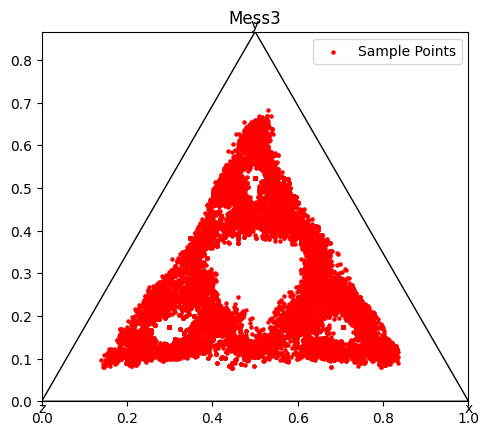

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to convert ternary coordinates to Cartesian coordinates
def ternary_to_cartesian(triples):
    points = []
    for triple in triples:
        x = 0.5 * (2 * triple[1] + triple[2])
        y = (np.sqrt(3) / 2) * triple[2]
        points.append([x, y])
    return np.array(points)

# Convert ternary coordinates to Cartesian coordinates
ternary_points = ternary_to_cartesian(points.cpu().detach().numpy())

# Plotting
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 1)
ax.set_ylim(0, np.sqrt(3) / 2)

# Draw the triangle
triangle = plt.Polygon([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]], edgecolor='k', fill=None)
ax.add_patch(triangle)

# Plot points
ax.scatter(ternary_points[:, 0], ternary_points[:, 1], color='red', label='Sample Points',s=5)

# Add labels
ax.text(0, 0, 'z', ha='center', va='top')
ax.text(1, 0, 'x', ha='center', va='top')
ax.text(0.5, np.sqrt(3) / 2, 'y', ha='center', va='bottom')

# Show plot
plt.title("Mess3")
plt.legend()
plt.show()
